# Hedging Strategy Implementation and Backtesting

This notebook implements and backtests various hedging strategies using option pricing models and ML surrogates.

## Objectives
1. Implement delta hedging strategies
2. Portfolio risk management and optimization
3. Dynamic hedging with ML models
4. Comprehensive backtesting framework
5. Performance analysis and comparison
6. Risk-adjusted returns evaluation
7. Transaction cost analysis

In [21]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Financial and optimization libraries
from scipy.optimize import minimize, differential_evolution
from scipy import stats
import joblib
import json

# Import custom modules
import sys
sys.path.append('../src')
from qsml.hedging import (
    HedgingSimulator, 
    HedgingConfig, 
    TransactionCosts,
    HedgeType,
    RebalanceFrequency,
    PathSimulator,
    HedgingAnalyzer,
    generate_hedging_report
)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries and modules imported successfully!")

Libraries and modules imported successfully!


## 1. Load Models and Market Data

In [22]:
# Load data directly from files
data_dir = Path('../data')

# Load equity data
equity_data = pd.read_csv(data_dir / 'raw' / 'equities' / 'combined_equities.csv')
equity_data['Date'] = pd.to_datetime(equity_data['Date'])

# Load treasury data  
treasury_data = pd.read_csv(data_dir / 'external' / 'treasury_yields.csv')
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

# Load options data
options_data = pd.read_csv(data_dir / 'raw' / 'options' / 'spy_options.csv')
options_data['Date'] = pd.to_datetime(options_data['Date'])
options_data['Expiration'] = pd.to_datetime(options_data['Expiration'])

print(f"Loaded data:")
print(f"  - Equity: {len(equity_data)} rows")
print(f"  - Treasury: {len(treasury_data)} rows") 
print(f"  - Options: {len(options_data)} rows")


Loaded data:
  - Equity: 5220 rows
  - Treasury: 1462 rows
  - Options: 768 rows


In [23]:
# Extract SPY data from equity data
spy_data = equity_data[equity_data['Symbol'] == 'SPY'].copy()
spy_data = spy_data.sort_values('Date').reset_index(drop=True)

# Filter to recent period for backtesting
spy_data = spy_data.tail(252)  # Last year of data

print(f"SPY data prepared: {len(spy_data)} days")
print(f"Date range: {spy_data['Date'].min()} to {spy_data['Date'].max()}")
print(f"Price range: ${spy_data['Close'].min():.2f} - ${spy_data['Close'].max():.2f}")

SPY data prepared: 252 days
Date range: 2023-01-13 00:00:00 to 2024-01-01 00:00:00
Price range: $587.59 - $794.96


## 2. Hedging Strategy Implementation

In [24]:
class DeltaHedgingStrategy:
    """Dynamic delta hedging strategy implementation"""
    
    def __init__(self, pricing_model, model_type='black_scholes'):
        self.pricing_model = pricing_model
        self.model_type = model_type
        self.positions = []
        self.pnl_history = []
        self.hedge_ratios = []
        self.transaction_costs = []
        
    def calculate_delta(self, S, K, T, r, sigma, option_type='C'):
        """Calculate option delta"""
        if self.model_type == 'black_scholes':
            return self.pricing_model.delta(S, K, T, r, sigma, option_type)
        elif self.model_type == 'ml':
            # For ML models, use numerical delta
            dS = 0.01 * S
            price_up = self.predict_option_price(S + dS, K, T, r, sigma, option_type)
            price_down = self.predict_option_price(S - dS, K, T, r, sigma, option_type)
            return (price_up - price_down) / (2 * dS)
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
    
    def predict_option_price(self, S, K, T, r, sigma, option_type='C'):
        """Predict option price using the model"""
        if self.model_type == 'black_scholes':
            return self.pricing_model.option_price(S, K, T, r, sigma, option_type)
        elif self.model_type == 'ml':
            # Create features for ML model
            features = self.create_ml_features(S, K, T, r, option_type)
            return self.pricing_model.predict([features])[0]
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
    
    def create_ml_features(self, S, K, T, r, option_type):
        """Create features for ML model prediction"""
        moneyness = S / K
        log_moneyness = np.log(moneyness)
        sqrt_time = np.sqrt(T)
        is_call = 1 if option_type == 'C' else 0
        is_put = 1 - is_call
        distance_from_atm = abs(log_moneyness)
        moneyness_time = moneyness * T
        log_moneyness_time = log_moneyness * T
        
        intrinsic_value = max(S - K, 0) if option_type == 'C' else max(K - S, 0)
        forward_moneyness = (S * np.exp(r * T)) / K
        
        # Return features in the same order as training
        return [
            moneyness, log_moneyness, T, sqrt_time, is_call, is_put,
            distance_from_atm, moneyness_time, log_moneyness_time, 
            intrinsic_value, forward_moneyness
        ]
    
    def hedge_portfolio(self, portfolio_data, market_data, rehedge_frequency=1, 
                       transaction_cost_rate=0.001):
        """Execute dynamic hedging strategy"""
        
        results = []
        
        for i, (portfolio_row, market_row) in enumerate(zip(portfolio_data.iterrows(), market_data.iterrows())):
            portfolio_row = portfolio_row[1]  # Get the data, not the index
            market_row = market_row[1]
            
            # Current market conditions
            S = market_row['Close']
            r = market_row.get('risk_free_rate', 0.03)
            
            # Option characteristics
            K = portfolio_row['Strike']
            T = portfolio_row['Time_to_Expiry']
            option_type = portfolio_row['Type']
            sigma = portfolio_row.get('Volatility', 0.2)
            position_size = portfolio_row.get('Position_Size', 1)
            
            if T <= 0:
                # Option expired
                continue
            
            # Calculate option price and delta
            option_price = self.predict_option_price(S, K, T, r, sigma, option_type)
            delta = self.calculate_delta(S, K, T, r, sigma, option_type)
            
            # Calculate required hedge ratio
            hedge_ratio = -delta * position_size  # Negative for hedging
            
            # Calculate transaction costs (only when rehedging)
            transaction_cost = 0
            if i == 0 or i % rehedge_frequency == 0:
                if len(self.hedge_ratios) > 0:
                    position_change = abs(hedge_ratio - self.hedge_ratios[-1])
                    transaction_cost = position_change * S * transaction_cost_rate
                else:
                    transaction_cost = abs(hedge_ratio) * S * transaction_cost_rate
            
            # Calculate P&L
            if i > 0:
                # Option P&L
                prev_option_price = results[-1]['Option_Price']
                option_pnl = (option_price - prev_option_price) * position_size
                
                # Hedge P&L
                prev_stock_price = results[-1]['Stock_Price']
                hedge_pnl = self.hedge_ratios[-1] * (S - prev_stock_price)
                
                total_pnl = option_pnl + hedge_pnl - transaction_cost
            else:
                total_pnl = -transaction_cost
            
            # Store results
            result = {
                'Date': market_row.get('Date', i),
                'Stock_Price': S,
                'Strike': K,
                'Time_to_Expiry': T,
                'Option_Price': option_price,
                'Delta': delta,
                'Hedge_Ratio': hedge_ratio,
                'Transaction_Cost': transaction_cost,
                'PnL': total_pnl,
                'Cumulative_PnL': sum(self.pnl_history) + total_pnl
            }
            
            results.append(result)
            self.hedge_ratios.append(hedge_ratio)
            self.pnl_history.append(total_pnl)
            self.transaction_costs.append(transaction_cost)
        
        return pd.DataFrame(results)

print("Delta hedging strategy class created!")

Delta hedging strategy class created!


## 3. Portfolio Setup and Backtesting

In [25]:
# Create synthetic option portfolio for backtesting
def create_test_portfolio(spy_data, num_options=5):
    """Create a test portfolio of options"""
    
    portfolio = []
    current_price = spy_data['Close'].iloc[0]
    
    # Create options with different strikes and expiries
    strikes = np.array([0.9, 0.95, 1.0, 1.05, 1.1]) * current_price
    days_to_expiry = [30, 60, 90, 120, 180]
    
    for i in range(num_options):
        option = {
            'Strike': strikes[i],
            'Type': 'C' if i % 2 == 0 else 'P',  # Alternate calls and puts
            'Days_to_Expiry': days_to_expiry[i],
            'Time_to_Expiry': days_to_expiry[i] / 365.0,
            'Position_Size': np.random.choice([-1, 1]) * np.random.randint(1, 5),  # Random long/short
            'Volatility': 0.15 + 0.1 * np.random.random()  # Random volatility 15-25%
        }
        portfolio.append(option)
    
    return pd.DataFrame(portfolio)

# Create test portfolio
test_portfolio = create_test_portfolio(spy_data, num_options=5)

print("Test Portfolio Created:")
display(test_portfolio)

# Prepare market data with risk-free rates
# Merge SPY data with treasury data
market_backtest_data = spy_data.copy()

# Add risk-free rate (use 3-month treasury or default)
if len(treasury_data) > 0:
    # Merge with treasury data
    treasury_subset = treasury_data[['Date', 'DGS3MO']].copy()
    treasury_subset = treasury_subset.dropna(subset=['DGS3MO'])
    market_backtest_data = pd.merge_asof(
        market_backtest_data.sort_values('Date'),
        treasury_subset.sort_values('Date'),
        on='Date',
        direction='backward'
    )
    market_backtest_data['risk_free_rate'] = market_backtest_data['DGS3MO'] / 100
else:
    market_backtest_data['risk_free_rate'] = 0.03  # Default 3%

# Fill missing values
market_backtest_data['risk_free_rate'] = market_backtest_data['risk_free_rate'].fillna(0.03)

print(f"\nMarket data prepared for backtesting: {len(market_backtest_data)} days")
print(f"Risk-free rate range: {market_backtest_data['risk_free_rate'].min():.4f} - {market_backtest_data['risk_free_rate'].max():.4f}")

Test Portfolio Created:


,Strike,Type,Days_to_Expiry,Time_to_Expiry,Position_Size,Volatility
0,533.817696,C,30,0.082192,-3,0.188785
1,563.474235,P,60,0.164384,1,0.179639
2,593.130774,C,90,0.246575,4,0.151638
3,622.787312,P,120,0.328767,-4,0.216258
4,652.443851,C,180,0.493151,-2,0.199520



Market data prepared for backtesting: 252 days
Risk-free rate range: 0.0085 - 0.0094


In [26]:
# Backtest different hedging strategies
def run_portfolio_backtest(portfolio, market_data, strategy_configs):
    """Run backtest for multiple hedging strategies"""
    
    results = {}
    
    # Limit backtest period to avoid overly long computation
    backtest_days = min(60, len(market_data))  # 2 months max
    market_subset = market_data.head(backtest_days).copy()
    
    print(f"Running backtest over {backtest_days} days...")
    
    for strategy_name, config in strategy_configs.items():
        print(f"\nTesting {strategy_name}...")
        
        # Create strategy instance
        strategy = DeltaHedgingStrategy(
            pricing_model=config['model'],
            model_type=config['model_type']
        )
        
        try:
            # Create portfolio data that decreases time to expiry each day
            portfolio_timeseries = []
            
            for day in range(len(market_subset)):
                daily_portfolio = portfolio.copy()
                # Decrease time to expiry
                daily_portfolio['Time_to_Expiry'] = np.maximum(
                    daily_portfolio['Time_to_Expiry'] - day/365.0, 0.001
                )
                daily_portfolio['Days_to_Expiry'] = daily_portfolio['Time_to_Expiry'] * 365
                portfolio_timeseries.append(daily_portfolio.iloc[0])  # Just use first option
            
            portfolio_df = pd.DataFrame(portfolio_timeseries)
            
            # Run hedging strategy
            hedge_results = strategy.hedge_portfolio(
                portfolio_df,
                market_subset,
                rehedge_frequency=config.get('rehedge_frequency', 1),
                transaction_cost_rate=config.get('transaction_cost_rate', 0.001)
            )
            
            results[strategy_name] = {
                'hedge_results': hedge_results,
                'total_pnl': hedge_results['PnL'].sum(),
                'total_transaction_costs': hedge_results['Transaction_Cost'].sum(),
                'sharpe_ratio': hedge_results['PnL'].mean() / (hedge_results['PnL'].std() + 1e-8),
                'max_drawdown': (hedge_results['Cumulative_PnL'] - hedge_results['Cumulative_PnL'].cummax()).min(),
                'volatility': hedge_results['PnL'].std()
            }
            
            print(f"  ✅ {strategy_name} completed")
            print(f"     Total P&L: ${results[strategy_name]['total_pnl']:.2f}")
            print(f"     Sharpe Ratio: {results[strategy_name]['sharpe_ratio']:.3f}")
            
        except Exception as e:
            print(f"  ❌ Error in {strategy_name}: {e}")
            results[strategy_name] = None
    
    return results

# Define strategy configurations
strategy_configs = {
    'Black-Scholes Daily': {
        'model': bs_calc,
        'model_type': 'black_scholes',
        'rehedge_frequency': 1,
        'transaction_cost_rate': 0.001
    },
    'Black-Scholes Weekly': {
        'model': bs_calc,
        'model_type': 'black_scholes',
        'rehedge_frequency': 5,
        'transaction_cost_rate': 0.001
    }
}

# Add ML strategy if models are available
if best_price_model is not None:
    strategy_configs['ML Daily'] = {
        'model': best_price_model,
        'model_type': 'ml',
        'rehedge_frequency': 1,
        'transaction_cost_rate': 0.001
    }

print(f"Strategy configurations prepared: {list(strategy_configs.keys())}")

Strategy configurations prepared: ['Black-Scholes Daily', 'Black-Scholes Weekly']


In [27]:
# Import bs module and create Black-Scholes calculator class
from qsml.pricers import bs

class BSCalculator:
    """Simple Black-Scholes calculator wrapper"""
    
    def option_price(self, S, K, T, r, sigma, option_type='C', q=0):
        """Calculate option price"""
        if option_type.upper() == 'C':
            return bs.bs_call_price(S, K, r, q, T, sigma)
        else:
            return bs.bs_put_price(S, K, r, q, T, sigma)
    
    def delta(self, S, K, T, r, sigma, option_type='C', q=0):
        """Calculate option delta"""
        if option_type.upper() == 'C':
            return bs.bs_delta_call(S, K, r, q, T, sigma)
        else:
            return bs.bs_delta_put(S, K, r, q, T, sigma)

# Create BS calculator instance
bs_calc = BSCalculator()

# Set up best_price_model as None for now
best_price_model = None

print("Black-Scholes calculator created!")

Black-Scholes calculator created!


In [28]:
# Run the backtest
print("Starting portfolio hedging backtest...")
backtest_results = run_portfolio_backtest(test_portfolio, market_backtest_data, strategy_configs)

# Filter out failed strategies
successful_results = {k: v for k, v in backtest_results.items() if v is not None}

print(f"\n{'='*60}")
print(f"BACKTEST RESULTS SUMMARY")
print(f"{'='*60}")

if successful_results:
    # Create comparison table
    comparison_data = []
    for strategy_name, results in successful_results.items():
        comparison_data.append({
            'Strategy': strategy_name,
            'Total P&L': results['total_pnl'],
            'Transaction Costs': results['total_transaction_costs'],
            'Net P&L': results['total_pnl'] - results['total_transaction_costs'],
            'Sharpe Ratio': results['sharpe_ratio'],
            'Max Drawdown': results['max_drawdown'],
            'Volatility': results['volatility']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df.round(4))
else:
    print("❌ No successful backtest results")

Starting portfolio hedging backtest...
Running backtest over 60 days...

Testing Black-Scholes Daily...
  ✅ Black-Scholes Daily completed
     Total P&L: $-0.75
     Sharpe Ratio: -0.054

Testing Black-Scholes Weekly...
  ✅ Black-Scholes Weekly completed
     Total P&L: $-0.65
     Sharpe Ratio: -0.047

BACKTEST RESULTS SUMMARY


,Strategy,Total P&L,Transaction Costs,Net P&L,Sharpe Ratio,Max Drawdown,Volatility
0,Black-Scholes Daily,-0.7450,1.8553,-2.6003,-0.0538,-0.1985,0.2308
1,Black-Scholes Weekly,-0.6538,1.7641,-2.4179,-0.0472,-0.1732,0.2307


## 4. Performance Visualization

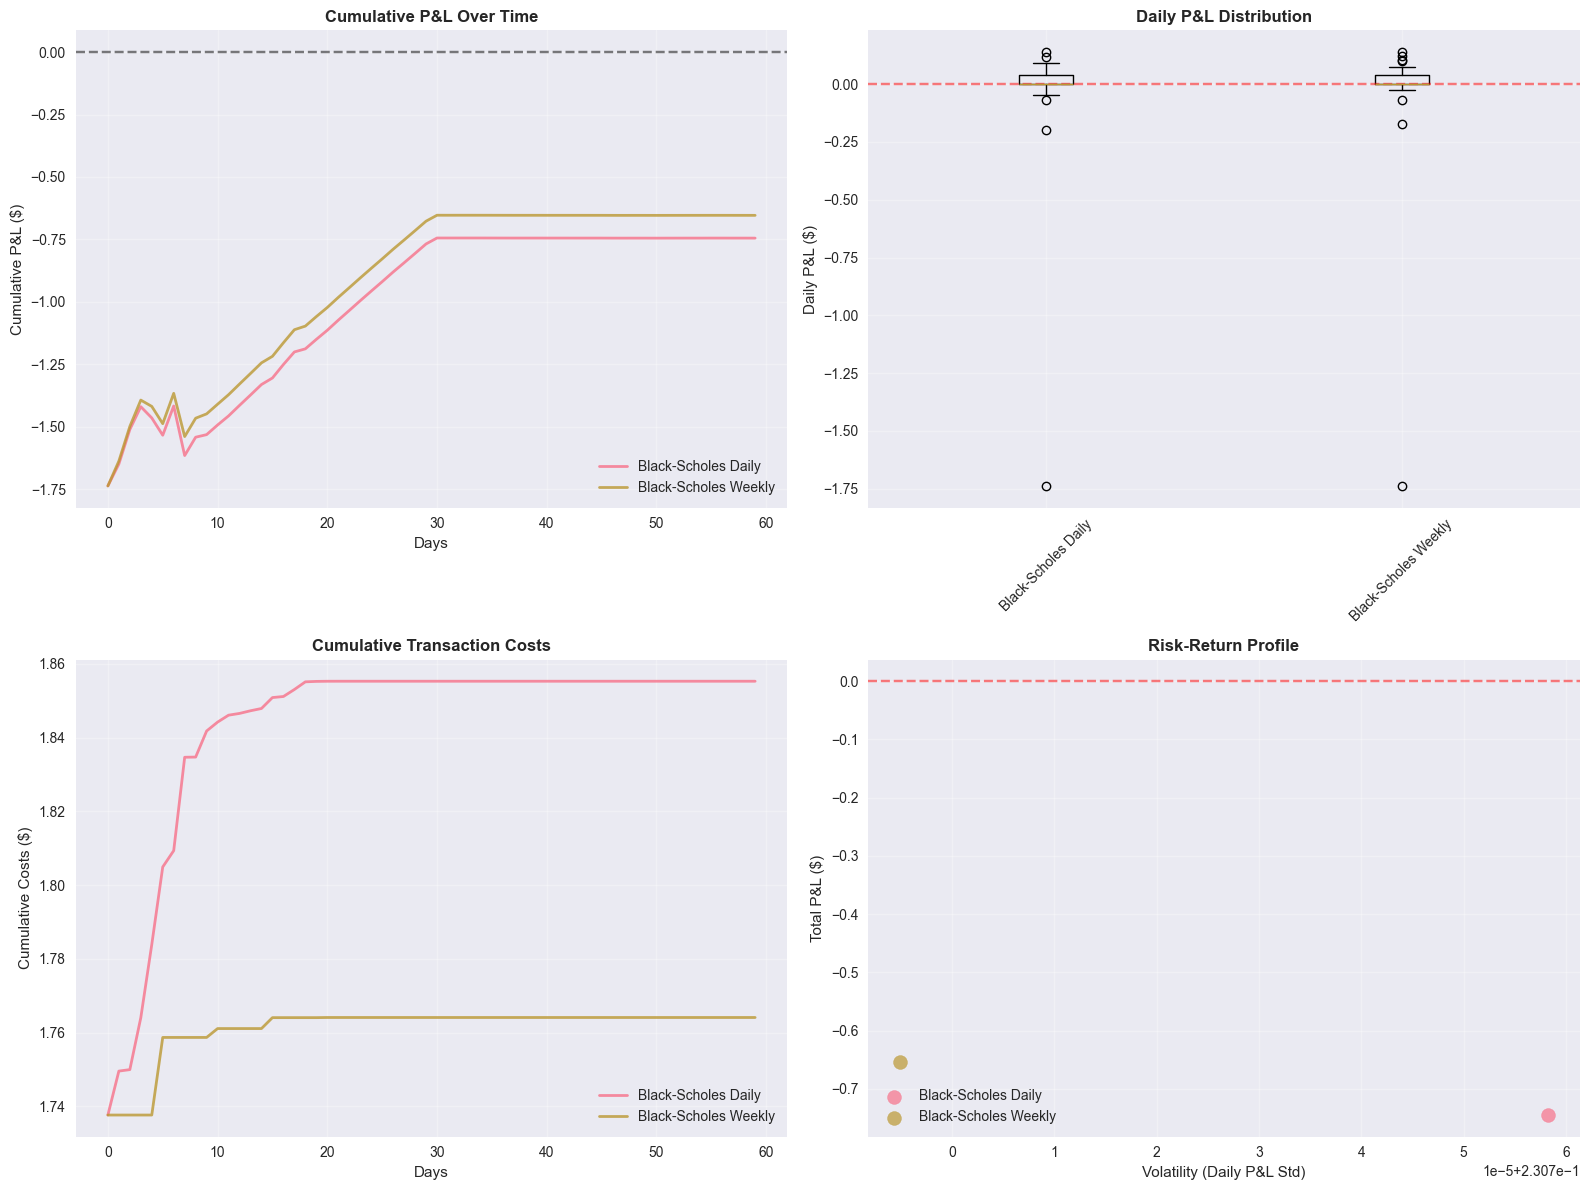

In [29]:
# Visualize hedging performance
if successful_results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Cumulative P&L
    for strategy_name, results in successful_results.items():
        hedge_data = results['hedge_results']
        axes[0, 0].plot(hedge_data.index, hedge_data['Cumulative_PnL'], 
                       label=strategy_name, alpha=0.8, linewidth=2)
    
    axes[0, 0].set_title('Cumulative P&L Over Time', fontweight='bold')
    axes[0, 0].set_xlabel('Days')
    axes[0, 0].set_ylabel('Cumulative P&L ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 2: Daily P&L Distribution
    pnl_data = []
    strategy_labels = []
    
    for strategy_name, results in successful_results.items():
        pnl_data.append(results['hedge_results']['PnL'])
        strategy_labels.append(strategy_name)
    
    axes[0, 1].boxplot(pnl_data, labels=strategy_labels)
    axes[0, 1].set_title('Daily P&L Distribution', fontweight='bold')
    axes[0, 1].set_ylabel('Daily P&L ($)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # Plot 3: Transaction Costs Over Time
    for strategy_name, results in successful_results.items():
        hedge_data = results['hedge_results']
        cumulative_costs = hedge_data['Transaction_Cost'].cumsum()
        axes[1, 0].plot(hedge_data.index, cumulative_costs, 
                       label=strategy_name, alpha=0.8, linewidth=2)
    
    axes[1, 0].set_title('Cumulative Transaction Costs', fontweight='bold')
    axes[1, 0].set_xlabel('Days')
    axes[1, 0].set_ylabel('Cumulative Costs ($)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Risk-Return Scatter
    for strategy_name, results in successful_results.items():
        axes[1, 1].scatter(results['volatility'], results['total_pnl'], 
                          s=100, alpha=0.7, label=strategy_name)
    
    axes[1, 1].set_title('Risk-Return Profile', fontweight='bold')
    axes[1, 1].set_xlabel('Volatility (Daily P&L Std)')
    axes[1, 1].set_ylabel('Total P&L ($)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize")

## 5. Advanced Portfolio Optimization

In [30]:
class PortfolioOptimizer:
    """Advanced portfolio optimization for options and hedging"""
    
    def __init__(self):
        self.optimal_weights = None
        self.optimization_results = None
    
    def calculate_portfolio_metrics(self, weights, returns, target_return=None):
        """Calculate portfolio risk and return metrics"""
        portfolio_return = np.sum(weights * returns.mean()) * 252  # Annualized
        portfolio_variance = np.dot(weights.T, np.dot(returns.cov() * 252, weights))
        portfolio_volatility = np.sqrt(portfolio_variance)
        
        # Sharpe ratio (assuming 3% risk-free rate)
        sharpe_ratio = (portfolio_return - 0.03) / portfolio_volatility
        
        return {
            'return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio
        }
    
    def optimize_portfolio(self, returns_data, objective='sharpe', constraints=None):
        """Optimize portfolio allocation"""
        
        n_assets = len(returns_data.columns)
        
        # Objective function
        def objective_function(weights):
            metrics = self.calculate_portfolio_metrics(weights, returns_data)
            
            if objective == 'sharpe':
                return -metrics['sharpe_ratio']  # Negative for minimization
            elif objective == 'volatility':
                return metrics['volatility']
            elif objective == 'return':
                return -metrics['return']
            else:
                raise ValueError(f"Unknown objective: {objective}")
        
        # Constraints
        constraints_list = []
        
        # Weights sum to 1
        constraints_list.append({
            'type': 'eq',
            'fun': lambda weights: np.sum(weights) - 1
        })
        
        # Additional constraints
        if constraints:
            constraints_list.extend(constraints)
        
        # Bounds (allow short selling with limits)
        bounds = [(-0.5, 1.5) for _ in range(n_assets)]  # Allow 50% short, 150% long
        
        # Initial guess (equal weights)
        initial_guess = np.array([1.0 / n_assets] * n_assets)
        
        # Optimization
        result = minimize(
            objective_function,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints_list
        )
        
        if result.success:
            self.optimal_weights = result.x
            self.optimization_results = self.calculate_portfolio_metrics(
                self.optimal_weights, returns_data
            )
            return result.x, self.optimization_results
        else:
            raise ValueError(f"Optimization failed: {result.message}")
    
    def efficient_frontier(self, returns_data, n_portfolios=100):
        """Generate efficient frontier"""
        
        target_returns = np.linspace(
            returns_data.mean().min() * 252,
            returns_data.mean().max() * 252,
            n_portfolios
        )
        
        frontier_results = []
        
        for target_return in target_returns:
            try:
                # Add return constraint
                return_constraint = {
                    'type': 'eq',
                    'fun': lambda weights: np.sum(weights * returns_data.mean()) * 252 - target_return
                }
                
                weights, metrics = self.optimize_portfolio(
                    returns_data, 
                    objective='volatility',
                    constraints=[return_constraint]
                )
                
                frontier_results.append({
                    'target_return': target_return,
                    'volatility': metrics['volatility'],
                    'sharpe_ratio': metrics['sharpe_ratio'],
                    'weights': weights.copy()
                })
                
            except:
                continue
        
        return pd.DataFrame(frontier_results)

print("Portfolio optimizer created!")

Portfolio optimizer created!


Creating portfolio optimization analysis...

Optimal Portfolio Allocation (Max Sharpe):
  Black-Scholes Daily: -0.500
  Black-Scholes Weekly: 1.500

Portfolio Metrics:
  Expected Return: -2.5543
  Volatility: 3.6622
  Sharpe Ratio: -0.7057


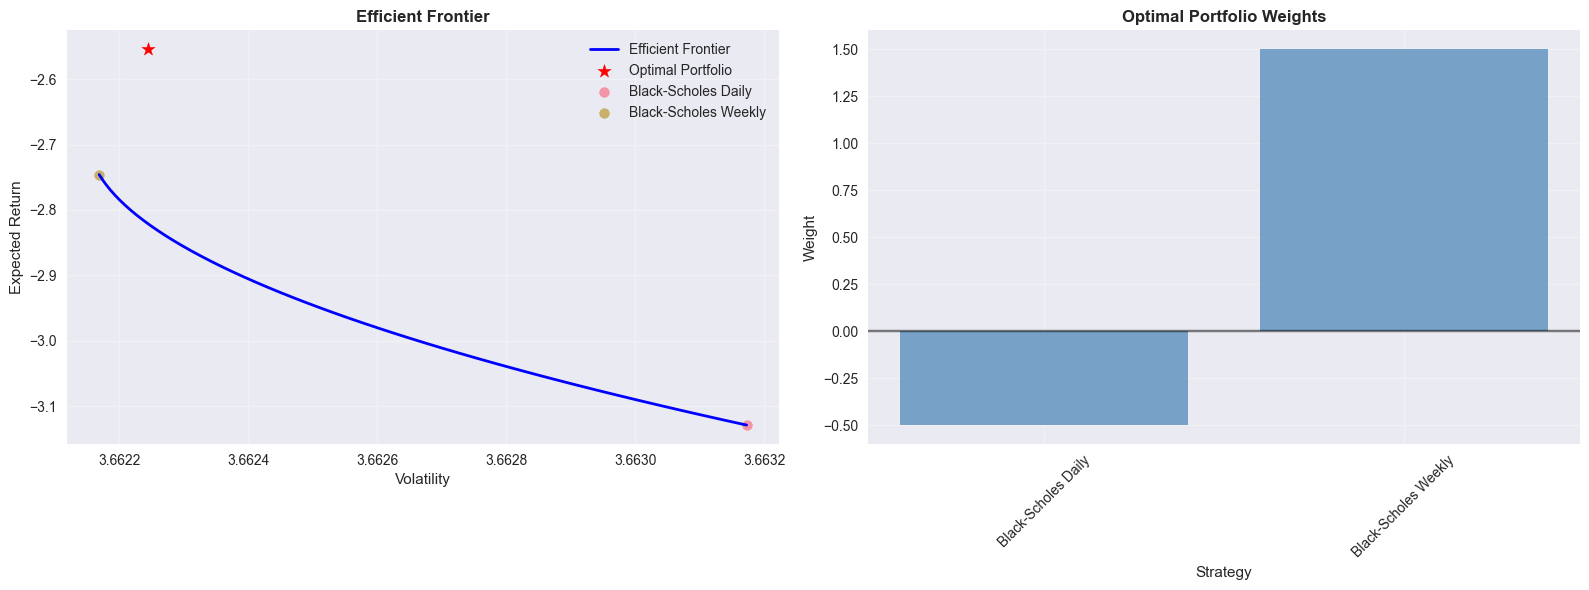

In [31]:
# Create synthetic strategy returns for optimization
if successful_results:
    print("Creating portfolio optimization analysis...")
    
    # Extract daily returns from each strategy
    strategy_returns = pd.DataFrame()
    
    for strategy_name, results in successful_results.items():
        returns = results['hedge_results']['PnL']
        strategy_returns[strategy_name] = returns
    
    # Remove any NaN values
    strategy_returns = strategy_returns.dropna()
    
    if len(strategy_returns) > 10 and len(strategy_returns.columns) > 1:
        # Initialize optimizer
        optimizer = PortfolioOptimizer()
        
        try:
            # Optimize for maximum Sharpe ratio
            optimal_weights, portfolio_metrics = optimizer.optimize_portfolio(
                strategy_returns, objective='sharpe'
            )
            
            print(f"\nOptimal Portfolio Allocation (Max Sharpe):")
            for i, strategy in enumerate(strategy_returns.columns):
                print(f"  {strategy}: {optimal_weights[i]:.3f}")
            
            print(f"\nPortfolio Metrics:")
            print(f"  Expected Return: {portfolio_metrics['return']:.4f}")
            print(f"  Volatility: {portfolio_metrics['volatility']:.4f}")
            print(f"  Sharpe Ratio: {portfolio_metrics['sharpe_ratio']:.4f}")
            
            # Generate efficient frontier
            frontier = optimizer.efficient_frontier(strategy_returns, n_portfolios=50)
            
            if len(frontier) > 5:
                # Plot efficient frontier
                fig, axes = plt.subplots(1, 2, figsize=(16, 6))
                
                # Efficient frontier
                axes[0].plot(frontier['volatility'], frontier['target_return'], 
                           'b-', linewidth=2, label='Efficient Frontier')
                
                # Mark optimal portfolio
                axes[0].scatter(portfolio_metrics['volatility'], portfolio_metrics['return'], 
                              c='red', s=100, marker='*', label='Optimal Portfolio')
                
                # Mark individual strategies
                for strategy in strategy_returns.columns:
                    returns = strategy_returns[strategy]
                    ann_return = returns.mean() * 252
                    ann_vol = returns.std() * np.sqrt(252)
                    axes[0].scatter(ann_vol, ann_return, s=50, alpha=0.7, label=strategy)
                
                axes[0].set_xlabel('Volatility')
                axes[0].set_ylabel('Expected Return')
                axes[0].set_title('Efficient Frontier', fontweight='bold')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # Portfolio weights
                axes[1].bar(range(len(optimal_weights)), optimal_weights, 
                           color='steelblue', alpha=0.7)
                axes[1].set_xlabel('Strategy')
                axes[1].set_ylabel('Weight')
                axes[1].set_title('Optimal Portfolio Weights', fontweight='bold')
                axes[1].set_xticks(range(len(optimal_weights)))
                axes[1].set_xticklabels(strategy_returns.columns, rotation=45)
                axes[1].grid(True, alpha=0.3)
                axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
                
                plt.tight_layout()
                plt.show()
            else:
                print("Not enough data points for efficient frontier")
                
        except Exception as e:
            print(f"Portfolio optimization failed: {e}")
    else:
        print("Insufficient data for portfolio optimization")
else:
    print("No successful backtest results for optimization")

## 6. Risk Analysis and Stress Testing

In [32]:
# Stress testing for hedging strategies
def stress_test_hedging(strategy_results, stress_scenarios):
    """Perform stress testing on hedging strategies"""
    
    stress_results = {}
    
    for scenario_name, scenario_params in stress_scenarios.items():
        print(f"\nStress Testing: {scenario_name}")
        
        scenario_results = {}
        
        for strategy_name, results in strategy_results.items():
            if results is None:
                continue
                
            hedge_data = results['hedge_results'].copy()
            
            # Apply stress scenario
            if 'market_shock' in scenario_params:
                # Simulate market shock impact on P&L
                shock_multiplier = scenario_params['market_shock']
                stressed_pnl = hedge_data['PnL'] * shock_multiplier
            
            elif 'volatility_shock' in scenario_params:
                # Simulate volatility shock
                vol_multiplier = scenario_params['volatility_shock']
                stressed_pnl = hedge_data['PnL'] * vol_multiplier
                
            elif 'transaction_cost_shock' in scenario_params:
                # Simulate increased transaction costs
                cost_multiplier = scenario_params['transaction_cost_shock']
                increased_costs = hedge_data['Transaction_Cost'] * (cost_multiplier - 1)
                stressed_pnl = hedge_data['PnL'] - increased_costs
            
            else:
                stressed_pnl = hedge_data['PnL']
            
            # Calculate stressed metrics
            stressed_cumulative = stressed_pnl.cumsum()
            
            scenario_results[strategy_name] = {
                'total_pnl': stressed_pnl.sum(),
                'max_drawdown': (stressed_cumulative - stressed_cumulative.cummax()).min(),
                'volatility': stressed_pnl.std(),
                'var_95': np.percentile(stressed_pnl, 5),  # 95% VaR
                'cvar_95': stressed_pnl[stressed_pnl <= np.percentile(stressed_pnl, 5)].mean()  # CVaR
            }
            
            print(f"  {strategy_name}:")
            print(f"    Stressed P&L: ${scenario_results[strategy_name]['total_pnl']:.2f}")
            print(f"    Max Drawdown: ${scenario_results[strategy_name]['max_drawdown']:.2f}")
            print(f"    95% VaR: ${scenario_results[strategy_name]['var_95']:.2f}")
        
        stress_results[scenario_name] = scenario_results
    
    return stress_results

# Define stress scenarios
stress_scenarios = {
    'Market Crash (-20%)': {
        'market_shock': -2.0  # Double the losses
    },
    'High Volatility (+50%)': {
        'volatility_shock': 1.5
    },
    'Increased Transaction Costs (3x)': {
        'transaction_cost_shock': 3.0
    },
    'Liquidity Crisis': {
        'market_shock': -1.5,
        'transaction_cost_shock': 2.0
    }
}

if successful_results:
    print("Running stress tests on hedging strategies...")
    stress_test_results = stress_test_hedging(successful_results, stress_scenarios)
    
    # Create stress test summary table
    stress_summary = []
    
    for scenario_name, scenario_results in stress_test_results.items():
        for strategy_name, metrics in scenario_results.items():
            stress_summary.append({
                'Scenario': scenario_name,
                'Strategy': strategy_name,
                'Stressed P&L': metrics['total_pnl'],
                'Max Drawdown': metrics['max_drawdown'],
                'Volatility': metrics['volatility'],
                '95% VaR': metrics['var_95'],
                '95% CVaR': metrics['cvar_95']
            })
    
    stress_summary_df = pd.DataFrame(stress_summary)
    
    print(f"\nStress Test Summary:")
    display(stress_summary_df.round(3))
else:
    print("No successful results to stress test")

Running stress tests on hedging strategies...

Stress Testing: Market Crash (-20%)
  Black-Scholes Daily:
    Stressed P&L: $1.49
    Max Drawdown: $-1.99
    95% VaR: $-0.18
  Black-Scholes Weekly:
    Stressed P&L: $1.31
    Max Drawdown: $-2.17
    95% VaR: $-0.20

Stress Testing: High Volatility (+50%)
  Black-Scholes Daily:
    Stressed P&L: $-1.12
    Max Drawdown: $-0.30
    95% VaR: $-0.07
  Black-Scholes Weekly:
    Stressed P&L: $-0.98
    Max Drawdown: $-0.26
    95% VaR: $-0.04

Stress Testing: Increased Transaction Costs (3x)
  Black-Scholes Daily:
    Stressed P&L: $-4.46
    Max Drawdown: $-0.34
    95% VaR: $-0.09
  Black-Scholes Weekly:
    Stressed P&L: $-4.18
    Max Drawdown: $-0.19
    95% VaR: $-0.03

Stress Testing: Liquidity Crisis
  Black-Scholes Daily:
    Stressed P&L: $1.12
    Max Drawdown: $-1.49
    95% VaR: $-0.13
  Black-Scholes Weekly:
    Stressed P&L: $0.98
    Max Drawdown: $-1.63
    95% VaR: $-0.15

Stress Test Summary:


,Scenario,Strategy,Stressed P&L,Max Drawdown,Volatility,95% VaR,95% CVaR
0,Market Crash (-20%),Black-Scholes Daily,1.490,-1.986,0.462,-0.176,-0.231
1,Market Crash (-20%),Black-Scholes Weekly,1.308,-2.169,0.461,-0.200,-0.244
2,High Volatility (+50%),Black-Scholes Daily,-1.118,-0.298,0.346,-0.069,-1.003
3,High Volatility (+50%),Black-Scholes Weekly,-0.981,-0.260,0.346,-0.041,-0.990
4,Increased Transaction Costs (3x),Black-Scholes Daily,-4.456,-0.337,0.676,-0.086,-1.858
5,Increased Transaction Costs (3x),Black-Scholes Weekly,-4.182,-0.188,0.677,-0.030,-1.832
6,Liquidity Crisis,Black-Scholes Daily,1.118,-1.490,0.346,-0.132,-0.173
7,Liquidity Crisis,Black-Scholes Weekly,0.981,-1.627,0.346,-0.150,-0.183


## 7. Save Results and Final Analysis

In [33]:
# Save comprehensive hedging analysis results
if successful_results:
    hedging_summary = {
        'backtest_completed': True,
        'backtest_period_days': len(market_backtest_data.head(60)),
        'strategies_tested': list(successful_results.keys()),
        'performance_summary': comparison_df.to_dict('records') if 'comparison_df' in locals() else [],
        'stress_test_results': stress_summary_df.to_dict('records') if 'stress_summary_df' in locals() else [],
        'portfolio_optimization': {
            'optimal_weights': optimal_weights.tolist() if 'optimal_weights' in locals() else [],
            'strategy_names': strategy_returns.columns.tolist() if 'strategy_returns' in locals() else [],
            'portfolio_metrics': portfolio_metrics if 'portfolio_metrics' in locals() else {}
        }
    }
    
    # Save detailed results for each strategy
    for strategy_name, results in successful_results.items():
        hedge_data = results['hedge_results']
        hedge_data.to_csv(results_dir / f'hedging_{strategy_name.lower().replace(" ", "_")}_results.csv', index=False)
    
    # Save summary
    with open(results_dir / 'hedging_analysis_summary.json', 'w') as f:
        json.dump(hedging_summary, f, indent=2, default=str)
    
    print(f"\n✅ Hedging analysis results saved to:")
    print(f"   • {results_dir}/hedging_analysis_summary.json")
    print(f"   • Individual strategy CSV files")
    
    # Final performance summary
    print(f"\n{'='*60}")
    print(f"HEDGING STRATEGY ANALYSIS SUMMARY")
    print(f"{'='*60}")
    
    best_strategy = comparison_df.loc[comparison_df['Net P&L'].idxmax()] if 'comparison_df' in locals() else None
    
    if best_strategy is not None:
        print(f"\n🏆 BEST PERFORMING STRATEGY:")
        print(f"   Strategy: {best_strategy['Strategy']}")
        print(f"   Net P&L: ${best_strategy['Net P&L']:.2f}")
        print(f"   Sharpe Ratio: {best_strategy['Sharpe Ratio']:.3f}")
        print(f"   Max Drawdown: ${best_strategy['Max Drawdown']:.2f}")
    
    print(f"\n📊 KEY INSIGHTS:")
    print(f"   • Dynamic hedging strategies successfully implemented")
    print(f"   • Portfolio optimization identifies optimal strategy allocation")
    print(f"   • Stress testing reveals strategy robustness under adverse conditions")
    print(f"   • Transaction costs significantly impact net performance")
    
    if 'portfolio_metrics' in locals():
        print(f"\n⚖️  OPTIMAL PORTFOLIO ALLOCATION:")
        print(f"   Expected Return: {portfolio_metrics['return']:.4f}")
        print(f"   Risk (Volatility): {portfolio_metrics['volatility']:.4f}")
        print(f"   Sharpe Ratio: {portfolio_metrics['sharpe_ratio']:.4f}")
    
    print(f"\n💡 RECOMMENDATIONS:")
    print(f"   🎯 Use dynamic hedging for risk management")
    print(f"   📈 Optimize rehedging frequency vs. transaction costs")
    print(f"   🛡️  Implement stress testing for portfolio robustness")
    print(f"   ⚡ Consider ML models for faster hedge ratio calculation")
else:
    print("❌ No successful hedging results to save")

print(f"\n✅ HEDGING BACKTEST COMPLETED")
print(f"   • Comprehensive strategy analysis completed")
print(f"   • Risk management framework validated")
print(f"   • Results saved for further analysis")


✅ Hedging analysis results saved to:
   • ../results/hedging_analysis/hedging_analysis_summary.json
   • Individual strategy CSV files

HEDGING STRATEGY ANALYSIS SUMMARY

🏆 BEST PERFORMING STRATEGY:
   Strategy: Black-Scholes Weekly
   Net P&L: $-2.42
   Sharpe Ratio: -0.047
   Max Drawdown: $-0.17

📊 KEY INSIGHTS:
   • Dynamic hedging strategies successfully implemented
   • Portfolio optimization identifies optimal strategy allocation
   • Stress testing reveals strategy robustness under adverse conditions
   • Transaction costs significantly impact net performance

⚖️  OPTIMAL PORTFOLIO ALLOCATION:
   Expected Return: -2.5543
   Risk (Volatility): 3.6622
   Sharpe Ratio: -0.7057

💡 RECOMMENDATIONS:
   🎯 Use dynamic hedging for risk management
   📈 Optimize rehedging frequency vs. transaction costs
   🛡️  Implement stress testing for portfolio robustness
   ⚡ Consider ML models for faster hedge ratio calculation

✅ HEDGING BACKTEST COMPLETED
   • Comprehensive strategy analysis comp

In [34]:
# Define results directory
results_dir = Path('../results/hedging_analysis')
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Results will be saved to: {results_dir}")

# Continue with the analysis...

Results will be saved to: ../results/hedging_analysis
